In [2]:
import pandas as pd
import pandahouse 
import scipy.stats as sts
import numpy as np
import seaborn as sns

In [3]:
connection = {
    'host': 'courses',
    'password': '1234',
    'user': 'student',
    'database': 'simulator'
}

q = '''SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
    FROM simulator.feed_actions 
    WHERE toDate(time) between '2022-05-24' and '2022-05-30'
    and exp_group in (1,2)
    GROUP BY exp_group, user_id
    '''

df = pandahouse.read_clickhouse(q, connection=connection)

In [4]:
df.head(5)

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


<AxesSubplot:xlabel='ctr', ylabel='Count'>

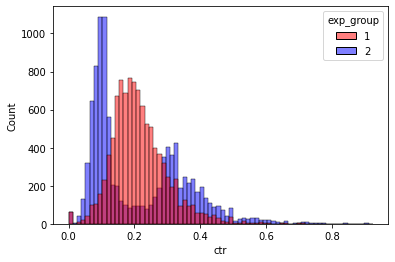

In [4]:
sns.histplot(data = df, x='ctr', hue='exp_group', palette = ['r', 'b'], alpha=0.5, kde=False)

In [5]:
#T-test
sts.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)

По результату t теста p value слишком высокий, у нас нет основания принять гипотезу о наличии статистически значимого различия.

In [6]:
#Тест Манна-Уитни
sts.mannwhitneyu(df[df.exp_group == 1].ctr, df[df.exp_group == 2].ctr, alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

По результату теста Манна-Уитни p value очень низкий, мы можем принять гипотезу о наличии статистически значимого различия между группами.

In [8]:
#Сглаженный CTR
def get_smoothed_ctr(user_likes, user_views, global_ctr, alpha):
    smoothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smoothed_ctr

In [9]:
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

In [10]:
smoothed_ctr_1 = df[df.exp_group == 1].apply(lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
smoothed_ctr_2 = df[df.exp_group == 2].apply(lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

In [11]:
sts.ttest_ind(smoothed_ctr_1, smoothed_ctr_2, equal_var=False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

На сглаженном CTR t тест показывает статистически значимые различия между группами.

In [ ]:
#Пуассоновский бутстреп

In [12]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = sts.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = sts.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [13]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

In [17]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<AxesSubplot:ylabel='Count'>

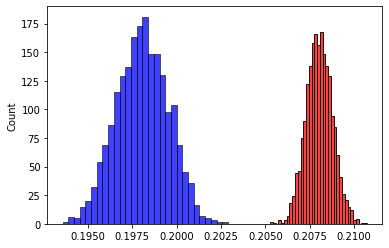

In [19]:
sns.histplot(ctr1, color='red')
sns.histplot(ctr2,color='blue')

<AxesSubplot:ylabel='Count'>

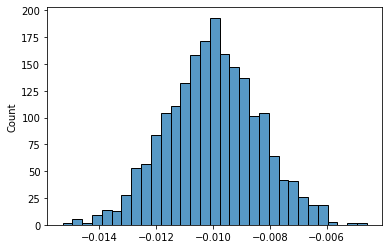

In [16]:
sns.histplot(ctr2-ctr1)

По результатам бутстрепа можно увидеть, что распределения CTR не пересекаются.
График распределения разницы не включает 0, это также позволяет сделать вывод о наличии различий между группами.
Однако все значения на графике разницы распределений отрицательные, а значения распреления CTR первой группы выше, чем у второй.
Это говорит о том, что результаты экспериментальной группы хуже,чем у контрольной. Таким образом, можно предположить, что новый алгоритм рекомендаций привел к ухудшению показателя CTR.

In [23]:
#Бакетное преобразование
q_2 = """
SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM simulator.feed_actions 
    WHERE toDate(time) between '2022-05-24' and '2022-05-30'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_2 = pandahouse.read_clickhouse(q_2, connection=connection)

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

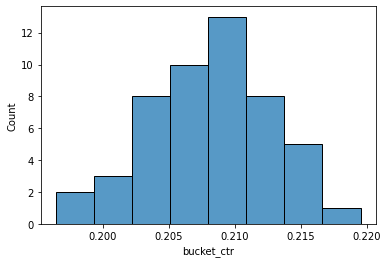

In [24]:
sns.histplot(df_2[df_2.exp_group == 1].bucket_ctr)

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

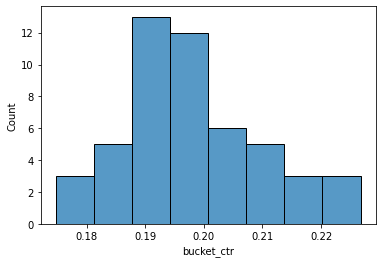

In [25]:
sns.histplot(df_2[df_2.exp_group == 2].bucket_ctr)

In [26]:
sts.ttest_ind(df_2[df_2.exp_group == 1].bucket_ctr, df_2[df_2.exp_group == 2].bucket_ctr, equal_var = False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

In [27]:
sts.mannwhitneyu(df_2[df_2.exp_group == 1].bucket_ctr, df_2[df_2.exp_group == 2].bucket_ctr, alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

Как t-тест, так и тест Манна-Уитни поверх бакетного преобразования показали статистически значимые различия между группами.

ВЫВОД:

1)Все тесты за исключением t-теста показали статистически значимые различия между группами. Можно предположить,что t-тест отработал некорректно, так как в обeих группах есть выбросы, распределение ctr второй группы - бимодальное, с большими по модулю отклонениями. Также не соблюдается условие гомогенности дисперсий внутри групп.

2)Бутстреп показал, что ctr во второй группе ниже,чем в контрольной, что противоречит гипотезе о том, что новый алгоритм приведет к увеличению метрики. Возможно, это связано c тем, что тест длился неделю, и в случае дольшей продолжительности результаты были бы иными. Также есть вероятность, что новый алгоритм рекомендаций действительно работает хуже (например, в связи с некорректными результатами предварительных исследований или отсутствием этих исследований).

3)Раскатывать новый алгоритм на основании данного теста не стоит, так как основная гипотеза не подтвердилась, а тесты показывают, что в экспериментальной группе целевая метрика ниже. Однако из-за бимодальности распределения второй группы, мы можем увидеть на графике, что есть часть пользователей, для которых ctr стал выше. Возможно имеет смысл провести доп.тесты для исследования этой группы.  